## Imports

In [2]:
import eduanalytics
from eduanalytics import model_data, pipeline_tools, reporting

In [3]:
import re, os, sys
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

## Explore results

In [4]:
path = eduanalytics.credentials_path
group = eduanalytics.credentials_group

engine = model_data.connect_to_database(path, group)

In [5]:
tbl_name = 'aoa_admissions'

In [8]:
results = model_data.get_data_for_modeling(engine, 
            tbl_name, status = 'predictions')

In [28]:
train = results[results.set == 'train']
test = results[results.set == 'test']

In [29]:
print(train.outcome.value_counts())
print(train.shape)

0.0    1109
1.0     201
Name: outcome, dtype: int64
(1310, 4)


In [30]:
print(test.outcome.value_counts())
print(test.shape)

0.0    241
1.0     30
Name: outcome, dtype: int64
(271, 4)


In [11]:
pkl_path = '/Volumes/IIME/EDS/data/admissions/pkls'

In [13]:
grid_search = reporting.load_model(pkl_path, 'aoa_admissions', 'rf_grid')

In [14]:
grid_search

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('dummyencoder', DummyEncoder()), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=N...imators=10, n_jobs=1, oob_score=False, random_state=1100,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'randomforestclassifier__n_estimators': [10, 50, 100, 200, 500, 1000], 'randomforestclassifier__max_depth': [1, 5, 10, 20, 50], 'randomforestclassifier__max_features': ['sqrt', 'log2'], 'randomforestclassifier__min_samples_split': [2, 5, 10], 'imputer__strategy': ['mean', 'median']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [24]:
risk_scores = test.predicted
hard_predictions = [1 if score >= 0.5 else 0 for score in risk_scores]

In [25]:
percentages = [15, 20]
hard_predictions_t1 = reporting.generate_binary_at_k(risk_scores, percentages[0])
hard_predictions_t2 = reporting.generate_binary_at_k(risk_scores, percentages[1])

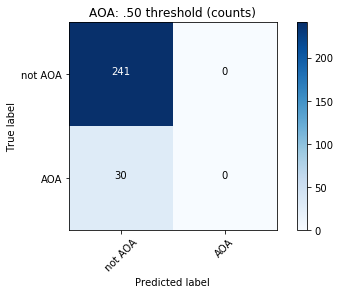

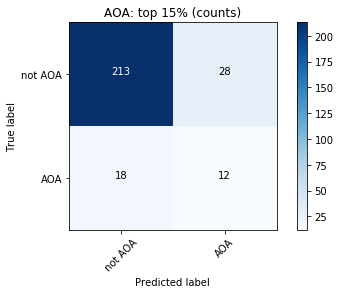

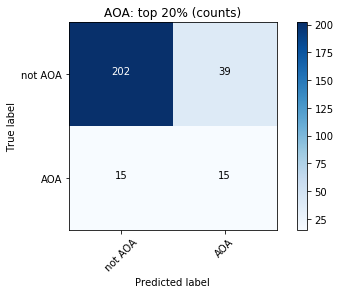

In [26]:
# Compute confusion matrix
class_names = ['not AOA', 'AOA']

labels = ['.50 threshold', 'top {}%'.format(percentages[0]), 'top {}%'.format(percentages[1])]
plots = zip([hard_predictions, hard_predictions_t1, hard_predictions_t2], labels)
title = class_names[1]

# Plot confusion matrix with counts
for predictions, label in plots:
    plt.figure()
    reporting.build_confusion_matrix(
    test.outcome, predictions, 
    class_names, 
    '{}: {}'.format(title, label))

plt.show()

In [34]:
forest = pipeline_tools.extract_model_from_pipeline(grid_search)
print(type(forest))

<class 'sklearn.ensemble.forest.RandomForestClassifier'>


In [35]:
transformed_columns = pipeline_tools.get_transformed_columns(grid_search)

In [36]:
transformed_columns

Index(['bcpm_gpa_cumulative', 'bcpm_hours_cumulative', 'total_gpa_cumulative',
       'bcpm_gpa_postbac', 'bcpm_hours_postbac', 'total_gpa_postbac',
       'bcpm_a_counts', 'bcpm_b_counts', 'bcpm_c_counts', 'bcpm_d_counts',
       'bcpm_f_counts', 'math_a_counts', 'math_b_counts', 'math_c_counts',
       'math_d_counts', 'biol_a_counts', 'biol_b_counts', 'biol_c_counts',
       'biol_d_counts', 'biol_f_counts', 'chem_a_counts', 'chem_b_counts',
       'chem_c_counts', 'chem_d_counts', 'phys_a_counts', 'phys_b_counts',
       'phys_c_counts', 'total_percentile', 'bio_percentile',
       'phy_chem_percentile', 'count_mcat', 'parent_edu_score',
       'median_income_zipcode', 'age_at_application',
       'num_schools_accepted_to', 'appl_year_2007.0', 'appl_year_2008.0',
       'appl_year_2009.0', 'appl_year_2010.0', 'appl_year_2011.0',
       'appl_year_2012.0', 'appl_year_2013.0', 'total_gpa_soph_higher_1.0',
       'total_gpa_soph_higher_nan', 'total_gpa_juni_higher_1.0',
       'total_

In [31]:
importances, std, indices = reporting.compute_feature_importances_ensemble(
    forest, transformed_columns)

1: clerkship_honors_count = 0.267
2: shelf_exam_above90_count = 0.071
3: school_exam_above90_count = 0.039
4: total_percentile = 0.038
5: total_gpa_cumulative = 0.035
6: bcpm_hours_cumulative = 0.035
7: bio_percentile = 0.033
8: phy_chem_percentile = 0.033
9: bcpm_gpa_cumulative = 0.032
10: bcpm_a_counts = 0.026
11: biol_a_counts = 0.025
12: chem_a_counts = 0.025
13: total_num_schools_accepted_to = 0.023
14: race_White = 0.022
15: age_at_application = 0.020
16: bcpm_b_counts = 0.019
17: math_a_counts = 0.018
18: biol_b_counts = 0.018
19: phys_a_counts = 0.016
20: chem_b_counts = 0.016
21: math_b_counts = 0.009
22: college_top_25_1.0 = 0.008
23: bcmp_gpa_soph_higher_1.0 = 0.008
24: phys_b_counts = 0.008
25: bcmp_gpa_juni_higher_1.0 = 0.008
26: shelf_exam_below65_count = 0.008
27: gender_M = 0.007
28: total_gpa_soph_higher_1.0 = 0.007
29: appl_year_2011.0 = 0.007
30: total_gpa_seni_higher_nan = 0.006
31: total_gpa_juni_higher_1.0 = 0.006
32: total_gpa_seni_higher_1.0 = 0.006
33: appl_yea

In [1]:
importances

NameError: name 'importances' is not defined

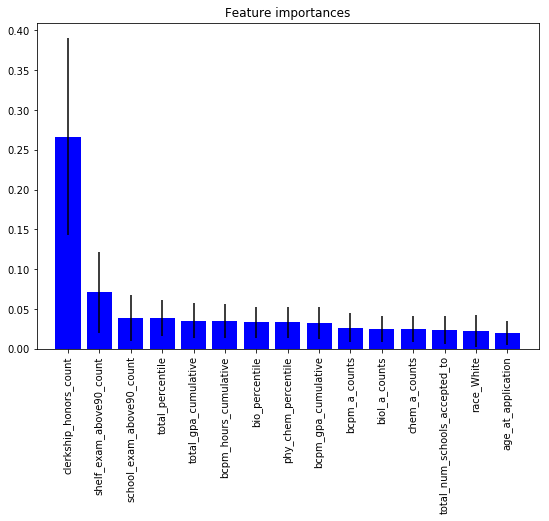

In [32]:
# Plot the feature importances of the forest
plt.figure(figsize=(9,6))
reporting.plot_feature_importances(
    importances, std, indices, transformed_columns)

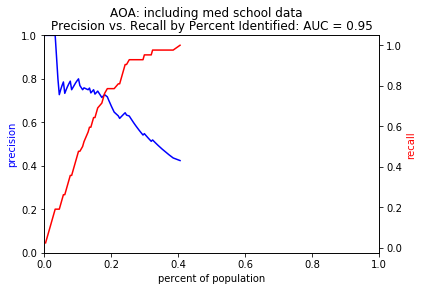

In [35]:
outcome = 'AOA'
features = 'including med school data'
reporting.plot_precision_recall_n(y_test, risk_scores, '{}: {}'.format(outcome, features))

In [ ]:
# TODO: Figure out how to output to database
# TODO: Figure out sklearn2pmml
# TODO: Multiclass classification
# TODO: Compare classifiers (logistic regression?)
# TODO: Incorporate lime
# TODO: Incorporate autosklearn?